In [13]:
# Set working directory to the Marigold repo root
# %cd /home/boxcat/workspace/labwork/depthmodel/Marigold2
%cd /home/boxcat/workspace/artslab/Marigold2/

import sys
import os
path = './Marigold2/script/depth/tumor.ipynb'
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(path), "..", "..")))

import yaml
import torch
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

import argparse
import logging
import shutil
import torch
from datetime import datetime, timedelta
from omegaconf import OmegaConf
from torch.utils.data import ConcatDataset, DataLoader
from tqdm import tqdm
from typing import List, Union


from marigold import MarigoldDepthPipeline
# Marigold-specific
from src.util.config_util import (
    find_value_in_omegaconf,
    recursive_load_config,
)
from marigold import MarigoldDepthPipeline
from src.dataset import BaseDepthDataset, DatasetMode, get_dataset
from src.dataset.mixed_sampler import MixedBatchSampler
from src.trainer import get_trainer_cls
from src.util.depth_transform import (
    DepthNormalizerBase,
    get_depth_normalizer,
)
from src.dataset import DatasetMode

/home/boxcat/workspace/artslab/Marigold2


In [14]:
# Update with your actual config path
config_path = "./config/train_marigold_mytumor.yaml"
print(f"Loading config from: {config_path}")

# Load and resolve the full config including nested dataset configs
cfg = recursive_load_config(config_path)
print(OmegaConf.to_yaml(cfg))  # Optional: view full config tree


Loading config from: ./config/train_marigold_mytumor.yaml
logging:
  filename: logging.log
  format: ' %(asctime)s - %(levelname)s -%(filename)s - %(funcName)s >> %(message)s'
  console_level: 20
  file_level: 10
wandb:
  project: marigold
dataset:
  train:
    batch_size: 2
    name: tumor_dataset
    type: paired_image_depth
    dir: ''
    filenames: data_split/tumor_depth/filenames_train.txt
    depth_format: image
    image_extension: png
    depth_extension: png
    has_invalid_depth: false
    shuffle: true
    drop_last: true
    infinite: true
  val:
  - name: tumor_dataset
    disp_name: mytumor_val
    dir: ''
    filenames: data_split/tumor_depth/filenames_val.txt
    depth_format: image
    image_extension: png
    depth_extension: png
    has_invalid_depth: false
  vis:
  - name: tumor_dataset
    disp_name: mytumor_vis
    dir: ''
    filenames: data_split/tumor_depth/filenames_vis.txt
    resize_to_hw:
    - 480
    - 640
model:
  name: marigold_pipeline
  pretrained_pa

In [15]:
#dirs and args
base_data_dir = './data'

#transforms
depth_transform: DepthNormalizerBase = get_depth_normalizer(cfg_normalizer=cfg.depth_normalization)

In [16]:
# Use get_dataset from src.dataset, which returns an instance of BaseDepthDataset
train_dataset: Union[BaseDepthDataset, List[BaseDepthDataset]] = get_dataset(
        cfg.dataset.train,
        base_data_dir=base_data_dir,
        mode=DatasetMode.TRAIN,
        augmentation_args=cfg.augmentation,
        depth_transform=depth_transform,
    )
print(f"Dataset loaded: {type(train_dataset)}")
print(f"Number of samples: {len(train_dataset)}")


Creating dataset: tumor_dataset (DatasetMode.TRAIN)
Dataset loaded: <class 'src.dataset.mytumor_dataset.MyTumorDataset'>
Number of samples: 1680


In [17]:
# Validation dataset
val_loaders: List[DataLoader] = []
for _val_dict in cfg.dataset.val:
    _val_dataset = get_dataset(
        _val_dict,
        base_data_dir=base_data_dir,
        mode=DatasetMode.EVAL,
    )
    print(f"Validation dataset loaded: {type(_val_dataset)}")
    print(f"Number of validation samples: {len(_val_dataset)}")
    _val_loader = DataLoader(
        dataset=_val_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=cfg.dataloader.num_workers,
    )
    val_loaders.append(_val_loader)

Creating dataset: tumor_dataset (DatasetMode.EVAL)
Validation dataset loaded: <class 'src.dataset.mytumor_dataset.MyTumorDataset'>
Number of validation samples: 420


In [18]:
# Basic DataLoader for debugging (not using MixedBatchSampler here)
dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=0
)


In [19]:
# Grab a batch
batch = next(iter(dataloader))

batch

{'rgb_int': tensor([[[[123, 119, 122,  ..., 255, 254, 254],
           [119, 120, 121,  ..., 255, 255, 255],
           [115, 122, 122,  ..., 254, 252, 255],
           ...,
           [ 99, 104, 104,  ..., 145, 147, 146],
           [ 99, 100, 103,  ..., 145, 145, 146],
           [ 98, 100, 103,  ..., 145, 144, 147]],
 
          [[253, 252, 252,  ..., 119, 118, 119],
           [254, 255, 255,  ..., 118, 122, 121],
           [252, 253, 253,  ..., 118, 120, 119],
           ...,
           [165, 164, 160,  ..., 100, 104, 102],
           [162, 161, 162,  ..., 102, 104, 104],
           [162, 162, 165,  ..., 100,  99, 102]],
 
          [[107, 108, 112,  ..., 107, 107, 108],
           [107, 106, 109,  ..., 105, 109, 106],
           [106, 107, 108,  ..., 107, 105, 105],
           ...,
           [173, 180, 175,  ..., 197, 195, 194],
           [181, 174, 177,  ..., 195, 200, 200],
           [178, 178, 178,  ..., 199, 201, 201]]]], dtype=torch.int32),
 'rgb_norm': tensor([[[[-0.035

In [20]:
print(batch.keys())

dict_keys(['rgb_int', 'rgb_norm', 'depth_raw_linear', 'depth_filled_linear', 'valid_mask_raw', 'valid_mask_filled', 'depth_raw_norm', 'depth_filled_norm', 'index', 'rgb_relative_path'])


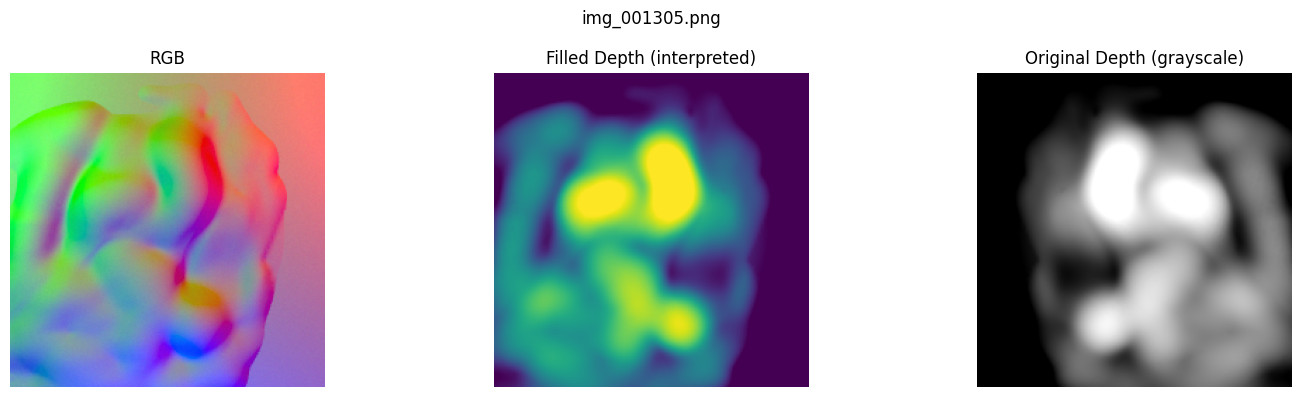

In [27]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import os

data_root = "./data/batch1"
depth_folder = os.path.join(data_root, "depths")

batch_size = batch['rgb_int'].shape[0]

for i in range(batch_size):
    # Get RGB image
    rgb = to_pil_image(batch['rgb_int'][i].byte())

    # Get filled depth from dataloader
    depth_filled = batch['depth_filled_linear'][i].squeeze(0).cpu().numpy()

    # Get original image name
    rgb_path = batch['rgb_relative_path'][i]
    image_name = os.path.basename(rgb_path)
    depth_path = os.path.join(depth_folder, image_name)

    if not os.path.exists(depth_path):
        print(f"⚠️ Missing file: {depth_path}")
        continue

    # Load original depth image
    depth_raw = Image.open(depth_path)

    # Display images
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(rgb)
    plt.title("RGB")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(depth_filled)
    plt.title("Filled Depth (interpreted)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(depth_raw, cmap='gray')  # Force black & white
    plt.title("Original Depth (grayscale)")
    plt.axis("off")

    plt.suptitle(image_name)
    plt.tight_layout()
    plt.show()
